# 20. Section Heatmaps

Build on the work done in notebook 19.

In [1]:
import os
import sys
import gc
import math
import logging
from typing import Tuple

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import multiprocessing
from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from keras import regularizers

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, concatenate, LeakyReLU
from keras import callbacks

from IPython.display import clear_output
import matplotlib.pyplot as plt

2023-03-08 10:29:54.595801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
# Set the GPU memory from growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-08 10:29:55.922083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 10:29:55.924237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 10:29:55.924388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Configure Logging

In [4]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.FileHandler("ex05_06.log"),
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-08 10:29:55 INFO     Started


## Load Source Data

In [5]:
# load the source training set
df_source = pd.read_csv('data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [6]:
# load the source training labels
df_source_labels = pd.read_csv('data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

### Functions to prepare the data

In [7]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [8]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

In [9]:
def select_sessions(
        y: pd.DataFrame,
        sample_size: int,
        random_state: int=1337) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Selects a sample of sessions from the dataset.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    sample_size : int
        The number of sessions to select.
    random_state : int
        The random state to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # create a sample for testing
    session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)

    # split the dataset into train, validation and test sets
    train, test = train_test_split(session_ids, test_size=0.4)
    test, val = train_test_split(test, test_size=0.5)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

### Functions for Model Training

In [10]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [11]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [12]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray,
        show_plots: bool = True) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    if show_plots:
        plot_loss(history)
        plot_accuracy(history)

    y_test_score = model.predict(X_test)
    #threshold, _, _ = optimize_f1(y_test, y_test_score)
    threshold = 0.5

    report = classification_report(y_test, y_test_score > threshold, zero_division=1)
    print(report)
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold, report

In [13]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [14]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [15]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None,
        clear_learning: bool = False,
        show_plots: bool = True) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    gc.collect()

    # clear the learning output if required
    if clear_learning:
        clear_output()

    return test_model(model, history, X_test, y_test, show_plots=show_plots)

## Pre-process Data

In [16]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [17]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


## Data Selection

In [18]:
random_state = 51
sample_size = df_source_labels['session_id'].nunique()

In [19]:
train, val, test = select_sessions(
    y=df_source_labels,
    sample_size=sample_size,
    random_state=random_state)

Train: 7067
Validation: 2356
Test: 2356


## Functions for Modeling Data

In [20]:
def create_room_heatmap(data: pd.DataFrame, fqid: str, level: int, 
                        bins:int = 10):
                        
    # select the data point to plot
    df_plot = data.query('fqid in @fqid and level == @level and event_name != "navigate_click"')
    df_plot = df_plot[['room_coor_x', 'room_coor_y']].dropna()    

    if (df_plot.shape[0] == 0):
        return np.zeros((bins, bins), dtype=np.uint8)

    # normalize the data points
    normalized_x = (df_plot.room_coor_x - (-1992.3545688360275)) / (1261.7737454550663 - (-1992.3545688360275))
    normalized_y = (df_plot.room_coor_y - (-918.1586870421452)) / (543.616424379599 - (-918.1586870421452))    

    # create the heatmap
    heatmap, xedges, yedges = np.histogram2d(
        x=normalized_y, 
        y=normalized_x, 
        bins=bins)
    
    # Apply logarithmic transformation
    heatmap = np.log(heatmap + 1)

    # Normalize the heatmap
    normalized_heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Scale the heatmap to the range 0-255
    scaled_heatmap = (normalized_heatmap * 255).astype(np.uint8)

    return scaled_heatmap
    
# # test the function
# heatmap = create_room_heatmap(df_source, 'directory', 15)
# print(heatmap.dtype)
# plt.imshow(heatmap, cmap='hot', origin='lower')
# plt.axis('off')
# plt.show()

In [21]:
def create_session_heatmap(X: pd.DataFrame,
                           y: pd.DataFrame,
                           session_id: str,
                           level_group: str,
                           df_combinations: pd.DataFrame):
    
    # select the data for the session           
    df_session_labels = y.query('session_id == @session_id and level_group == @level_group')
    df_session = X.query('session_id == @session_id and level_group == @level_group')
    
    # create the answer array
    index_offset = 0
    answer_array = []
    if (level_group == '0-4'):
        index_offset = 1
        answer_array = np.zeros(3)
    elif (level_group == '5-12'):
        index_offset = 4
        answer_array = np.zeros(10)
    elif (level_group == '13-22'):
        index_offset = 14
        answer_array = np.zeros(5)
    else:
        raise ValueError('level_group not supported')

    # iterate over all the questions answered in the session
    heatmap_array = []
    for _, row in df_session_labels.iterrows():
        question_number = row['question_num']
        correct = row['correct']

        # update the answer array
        answer_array[question_number - index_offset] = correct

    # iterate over all the combinations
    for i, row in df_combinations.iterrows():
        fqid = row.fqid
        level = row.level

        heatmap_array.append(create_room_heatmap(df_session, fqid, level))   

    return heatmap_array, answer_array


In [22]:
def create_heatmap_dataset(X: pd.DataFrame,
                           y: pd.DataFrame,
                           session_list: list,
                           level_group: str):

    X_features = []
    y_dataset = []

    # get the unique combinations for the level group     
    df_combinations = X \
        .query('event_name != "navigate_click" and level_group == @level_group') \
        .groupby(['level_group', 'fqid', 'level']) \
        .agg({'session_id': 'nunique'}) \
        .reset_index() \
        .loc[lambda x: x['session_id'] > 5000] \
        .drop(columns=['session_id']) \
        .drop_duplicates() \
        .reset_index(drop=True)

    for session_id in tqdm(session_list):
        features, target = create_session_heatmap(
            X=X,
            y=y,
            session_id=session_id,
            level_group=level_group,
            df_combinations=df_combinations)
        
        X_features.append(features)
        y_dataset.append(target)

    X_out = np.array(X_features, dtype=np.float64)
    y_out = np.array(y_dataset)

    return X_out, y_out
# test the function
X_out, y_out = create_heatmap_dataset(
    X=df_source, 
    y=df_source_labels, 
    session_list=df_source.session_id.unique()[:3],
    level_group='13-22')

print(X_out.shape, y_out.shape)

  0%|          | 0/3 [00:00<?, ?it/s]

(3, 56, 10, 10) (3, 5)


## Load Modeling Datasets

In [23]:
# load level 0-4
X_train_0_4 = np.load('data/19/X_train_0_4.npz')['arr_0']
X_val_0_4 = np.load('data/19/X_val_0_4.npz')['arr_0']
X_test_0_4 = np.load('data/19/X_test_0_4.npz')['arr_0']

y_train_0_4 = np.load('data/19/y_train_0_4.npz')['arr_0']
y_val_0_4 = np.load('data/19/y_val_0_4.npz')['arr_0']
y_test_0_4 = np.load('data/19/y_test_0_4.npz')['arr_0']

In [24]:
# load level 5-12
X_train_5_12 = np.load('data/19/X_train_5_12.npz')['arr_0']
X_val_5_12 = np.load('data/19/X_val_5_12.npz')['arr_0']
X_test_5_12 = np.load('data/19/X_test_5_12.npz')['arr_0']

y_train_5_12 = np.load('data/19/y_train_5_12.npz')['arr_0']
y_val_5_12 = np.load('data/19/y_val_5_12.npz')['arr_0']
y_test_5_12 = np.load('data/19/y_test_5_12.npz')['arr_0']

In [25]:
# load level 13-22
X_train_13_22 = np.load('data/19/X_train_13_22.npz')['arr_0']
X_val_13_22 = np.load('data/19/X_val_13_22.npz')['arr_0']
X_test_13_22 = np.load('data/19/X_test_13_22.npz')['arr_0']

y_train_13_22 = np.load('data/19/y_train_13_22.npz')['arr_0']
y_val_13_22 = np.load('data/19/y_val_13_22.npz')['arr_0']
y_test_13_22 = np.load('data/19/y_test_13_22.npz')['arr_0']

In [26]:
model_datasets = {
    '0-4': {
        'train': { 'features': X_train_0_4, 'target': y_train_0_4 },
        'val': { 'features': X_val_0_4, 'target': y_val_0_4 },
        'test': { 'features': X_test_0_4, 'target': y_test_0_4 },
        'question_offset': 1
    },
    '5-12': {
        'train': { 'features': X_train_5_12, 'target': y_train_5_12 },
        'val': { 'features': X_val_5_12, 'target': y_val_5_12 },
        'test': { 'features': X_test_5_12, 'target': y_test_5_12 },
        'question_offset': 4
    },
    '13-22': {
        'train': { 'features': X_train_13_22, 'target': y_train_13_22 },
        'val': { 'features': X_val_13_22, 'target': y_val_13_22 },
        'test': { 'features': X_test_13_22, 'target': y_test_13_22 },
        'question_offset': 14
    },
}

## Model Training

In [27]:
def get_model(input_shape: tuple, output_shape:int) -> keras.models:
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    return model

def train_group_model(data: dict, 
                level_group: str, 
                epochs: int, 
                batch_size: int, 
                optimizer, 
                loss: str, 
                metrics: list,
                clear_learning: bool=False,
                show_plots: bool=True) -> keras.models:
    
    # get the level group dataset
    level_dataset = data[level_group]

     # get the input shape
    input_shape = (level_dataset['train']['features'].shape[1],
                   level_dataset['train']['features'].shape[2],
                   level_dataset['train']['features'].shape[3])
    
    output_shape = level_dataset['train']['target'].shape[1]
    
    # get the model
    model = get_model(input_shape, output_shape)

    # perform the training
    _, report = train_and_test_model(
        model=model,
        X_train=level_dataset['train']['features'],
        y_train=level_dataset['train']['target'],
        X_val=level_dataset['val']['features'],
        y_val=level_dataset['val']['target'],
        X_test=level_dataset['test']['features'],
        y_test=level_dataset['test']['target'],
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        clear_learning=clear_learning,
        show_plots=show_plots)

    # return the model
    return model, report

# # test the function
# _, _ = train_group_model(
#     data=model_datasets,
#     level_group='5-12',
#     epochs=10,
#     batch_size=200,
#     optimizer=optimizers.RMSprop(lr=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy'],
#     clear_learning=False,
#     show_plots=True)



### Train Level Group Models

In [28]:
group_models = {}

Epoch 1/10


2023-03-08 10:30:40.368795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 10:30:40.369429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 10:30:40.369637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 10:30:40.369787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

23/36 [==================>...........] - ETA: 0s - loss: 6.0963 - accuracy: 0.2330  

2023-03-08 10:30:41.470580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


36/36 [==============================] - 1s 6ms/step - loss: 4.4129 - accuracy: 0.2168 - val_loss: 1.1197 - val_accuracy: 0.2551
Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 1.0646 - accuracy: 0.1569 - val_loss: 0.7090 - val_accuracy: 0.2551
Epoch 3/10
36/36 [==============================] - 0s 3ms/step - loss: 0.7434 - accuracy: 0.1721 - val_loss: 0.5175 - val_accuracy: 0.2551
Epoch 4/10
36/36 [==============================] - 0s 3ms/step - loss: 0.8148 - accuracy: 0.2125 - val_loss: 0.6256 - val_accuracy: 0.2551
Epoch 5/10
36/36 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.2631 - val_loss: 0.5709 - val_accuracy: 0.2551
Epoch 6/10
36/36 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.2649 - val_loss: 0.3835 - val_accuracy: 0.2551
Epoch 7/10
36/36 [==============================] - 0s 3ms/step - loss: 0.5413 - accuracy: 0.2812 - val_loss: 0.3620 - val_accuracy: 0.2551
Epoch 8/10
36/36 [=============

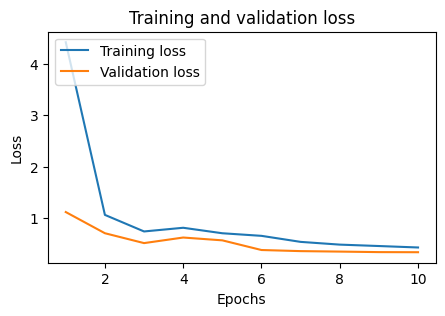

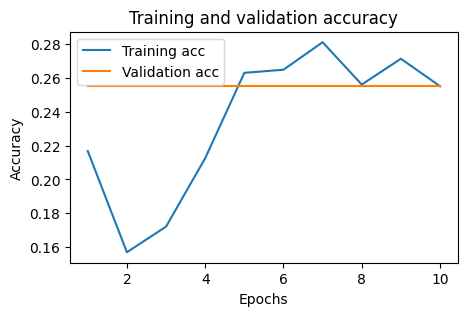

74/74 [==============================] - 0s 587us/step
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1717
           1       0.98      1.00      0.99      2307
           2       0.93      1.00      0.96      2193

   micro avg       0.88      1.00      0.94      6217
   macro avg       0.88      1.00      0.93      6217
weighted avg       0.89      1.00      0.94      6217
 samples avg       0.88      1.00      0.92      6217

Optimized threshold for best F1: 0.50


In [29]:
group_models['0-4'], _ = train_group_model(
    data=model_datasets,
    level_group='0-4',
    epochs=10,
    batch_size=200,
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    clear_learning=False,
    show_plots=True)

Epoch 1/10
36/36 [==============================] - 1s 8ms/step - loss: 3.2461 - accuracy: 0.0299 - val_loss: 1.1622 - val_accuracy: 0.0047
Epoch 2/10
36/36 [==============================] - 0s 5ms/step - loss: 1.0447 - accuracy: 0.0042 - val_loss: 0.8889 - val_accuracy: 0.0047
Epoch 3/10
36/36 [==============================] - 0s 5ms/step - loss: 0.8811 - accuracy: 0.0051 - val_loss: 0.7639 - val_accuracy: 0.0038
Epoch 4/10
36/36 [==============================] - 0s 5ms/step - loss: 2.0819 - accuracy: 0.0195 - val_loss: 2.2287 - val_accuracy: 0.0042
Epoch 5/10
36/36 [==============================] - 0s 5ms/step - loss: 1.2516 - accuracy: 0.0072 - val_loss: 0.7438 - val_accuracy: 0.0038
Epoch 6/10
36/36 [==============================] - 0s 5ms/step - loss: 1.0965 - accuracy: 0.0113 - val_loss: 0.7238 - val_accuracy: 0.0038
Epoch 7/10
36/36 [==============================] - 0s 5ms/step - loss: 1.0456 - accuracy: 0.0180 - val_loss: 0.7037 - val_accuracy: 0.0038
Epoch 8/10
36/36 [==

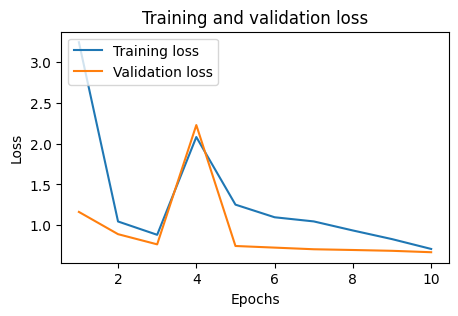

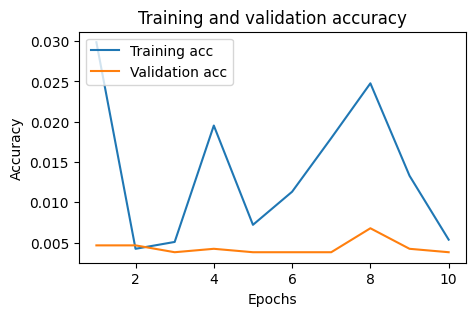

74/74 [==============================] - 0s 621us/step
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1880
           1       0.54      1.00      0.70      1261
           2       0.77      1.00      0.87      1817
           3       0.72      1.00      0.84      1707
           4       0.62      1.00      0.76      1450
           5       0.73      1.00      0.84      1720
           6       0.50      1.00      0.67      1176
           7       0.64      1.00      0.78      1507
           8       0.87      1.00      0.93      2040
           9       1.00      0.00      0.00       637

   micro avg       0.69      0.96      0.80     15195
   macro avg       0.72      0.90      0.73     15195
weighted avg       0.72      0.96      0.79     15195
 samples avg       0.69      0.96      0.78     15195

Optimized threshold for best F1: 0.50


In [30]:
group_models['5-12'], _ = train_group_model(
    data=model_datasets,
    level_group='5-12',
    epochs=10,
    batch_size=200,
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    clear_learning=False,
    show_plots=True)

Epoch 1/10
36/36 [==============================] - 1s 9ms/step - loss: 4.4183 - accuracy: 0.1296 - val_loss: 1.2750 - val_accuracy: 0.1405
Epoch 2/10
36/36 [==============================] - 0s 6ms/step - loss: 1.1131 - accuracy: 0.1371 - val_loss: 2.4808 - val_accuracy: 0.0357
Epoch 3/10
36/36 [==============================] - 0s 6ms/step - loss: 1.1339 - accuracy: 0.0252 - val_loss: 0.7928 - val_accuracy: 0.0267
Epoch 4/10
36/36 [==============================] - 0s 6ms/step - loss: 2.8961 - accuracy: 0.0528 - val_loss: 0.7907 - val_accuracy: 0.0263
Epoch 5/10
36/36 [==============================] - 0s 6ms/step - loss: 2.2269 - accuracy: 0.0630 - val_loss: 0.7823 - val_accuracy: 0.0267
Epoch 6/10
36/36 [==============================] - 0s 6ms/step - loss: 1.0505 - accuracy: 0.0303 - val_loss: 0.7331 - val_accuracy: 0.0267
Epoch 7/10
36/36 [==============================] - 0s 6ms/step - loss: 1.3619 - accuracy: 0.0550 - val_loss: 2.2013 - val_accuracy: 0.0267
Epoch 8/10
36/36 [==

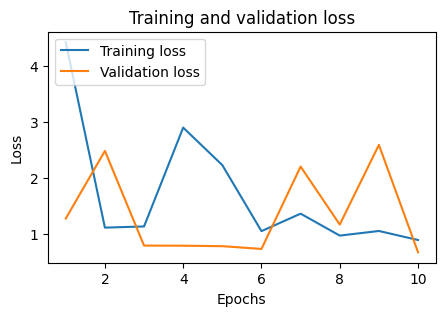

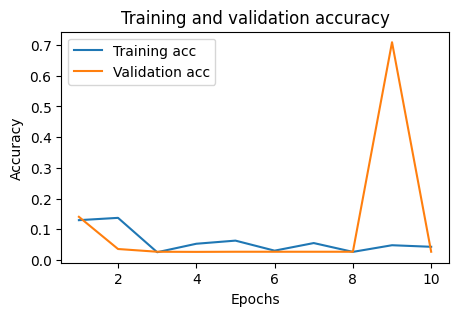

74/74 [==============================] - 0s 612us/step
              precision    recall  f1-score   support

           0       0.72      1.00      0.83      1686
           1       1.00      0.00      0.00      1147
           2       0.73      1.00      0.85      1726
           3       0.68      1.00      0.81      1611
           4       0.95      1.00      0.98      2245

   micro avg       0.77      0.86      0.81      8415
   macro avg       0.82      0.80      0.69      8415
weighted avg       0.82      0.86      0.76      8415
 samples avg       0.77      0.88      0.80      8415

Optimized threshold for best F1: 0.50


In [31]:
group_models['13-22'], _ = train_group_model(
    data=model_datasets,
    level_group='13-22',
    epochs=10,
    batch_size=200,
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    clear_learning=False,
    show_plots=True)

## Putting it all together

In [121]:
y_true = []
y_pred = []

for session_index, session_id in enumerate(tqdm(test)):
    df_session_labels = df_source_labels[df_source_labels['session_id'] == session_id]

    # process each row in the session
    for row_index, row in df_session_labels.iterrows():
        question_number = row['question_num']
        level_group = row['level_group']
        correct = row['correct']

        #print('question_number: ', question_number, level_group, correct)

        # get the model
        model = group_models[level_group]

        # get the session heatmap
        heatmap =  model_datasets[level_group]['test']['features'][session_index]

        # perform the prediction
        predictions = (model.predict(np.array([heatmap]), verbose=False) > 0.5).astype("int32")[0]

        y_true.append(correct)
        y_pred.append(predictions[question_number - model_datasets[level_group]['question_offset']])

    # if session_index > 100:
    #     break

print(classification_report(y_true, y_pred))

  0%|          | 0/2356 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      0.23      0.34     12596
           1       0.74      0.94      0.83     29812

    accuracy                           0.73     42408
   macro avg       0.68      0.59      0.58     42408
weighted avg       0.71      0.73      0.68     42408

